## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

## Описание данных

Данные лежат в файле /datasets/taxi.csv.
Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

##  Содержание проекта

<a href='#step1'>1.Подготовках</a>

<a href='#step2'>2.Анализ</a>

<a href='#step3'>3.Обучение</a>

<a href='#step4'>4.Тестирование</a>

# 1. Подготовка <a id='step1'></a>

Загрузка необходимых библиотек

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 

import time 
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

RND = 12345

Загрузим и осмотрим данные

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null datetime64[ns]
num_orders    26496 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Подготовим данные

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [5]:
df = df.set_index('datetime')

In [6]:
df.sort_index(inplace=True)

In [7]:
df = df.resample('1H').sum()

In [8]:
df.index.is_monotonic

True

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


### Вывод

В наборе данных 26496 наблюдений и 2 столбца

Обнаружены следующие признаки:

* datetime — отсечка временного периода, состоит из даты и времени
* num_orders — количество заказов

Данные ресемплированы, расположены в хронологическом порядке


# 2. Анализ <a id='step2'></a>

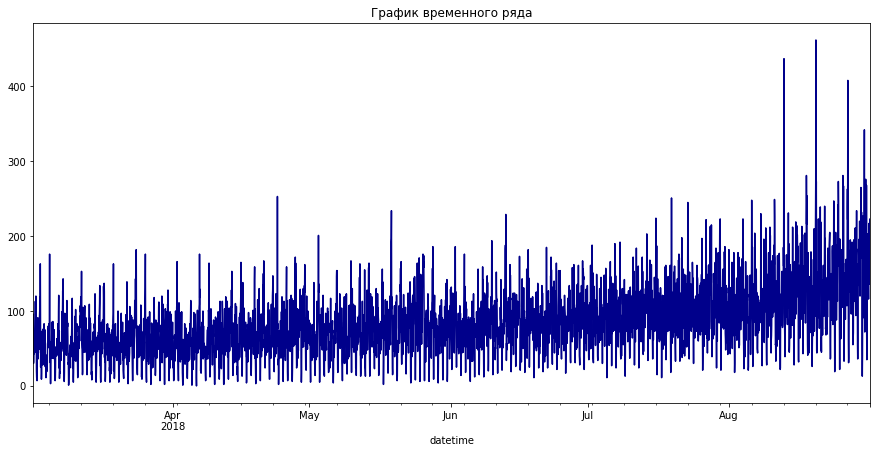

In [41]:
df['num_orders'].plot(title='График временного ряда', figsize=(15,7), color='#00008b')

Первичный график нечитабелен. Проведем ресемплирование по часам. Найдем скользящее среднее

In [11]:
new_df = df.copy()
new_df = new_df.resample('1H').sum()
new_df['rolling_mean'] = new_df['num_orders'].shift().rolling(12).mean()
new_df['std'] = new_df['num_orders'].rolling(12).std()
new_df = new_df.dropna()

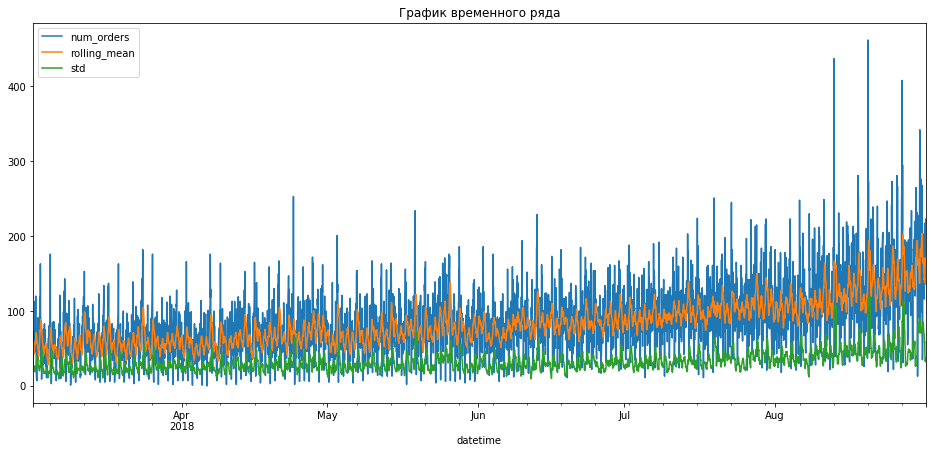

In [40]:
new_df[['num_orders', 'rolling_mean', 'std']].plot(title='График временного ряда', figsize=(16,7))

Проведем декомпозицию для просмотра тренда и сезонности

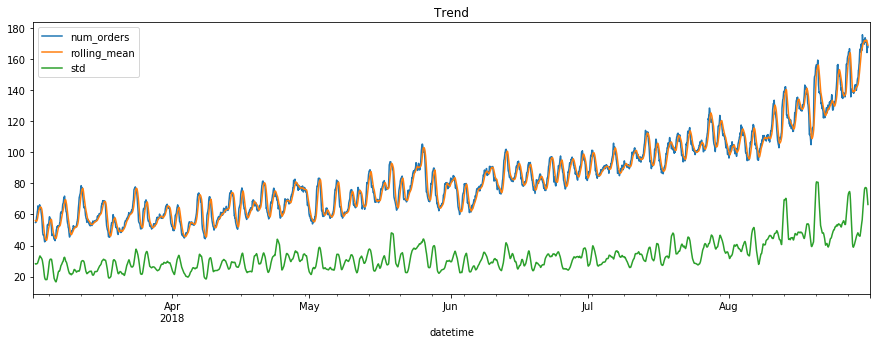

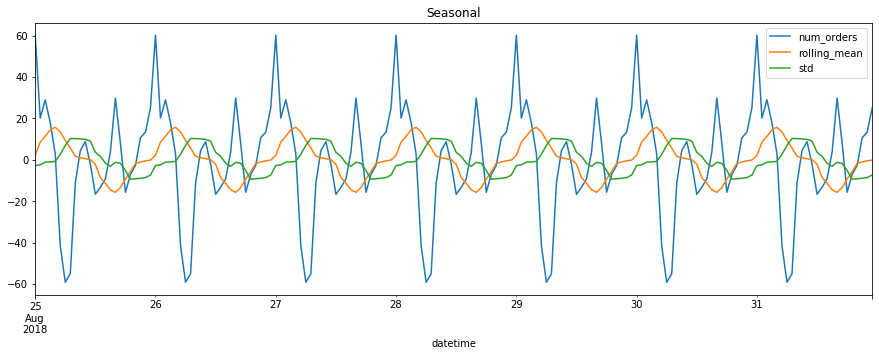

In [13]:
decomposed_df = seasonal_decompose(new_df)
decomposed_df.trend.plot(title='Trend', figsize=(15,5))
decomposed_df.seasonal.tail(24*7).plot(title='Seasonal', figsize=(15,5))

Рассмотрим сезонность подробней. В течении дня

### Вывод

Среднее значение и стандартное отклонение со временем увеличиваются, значит временной ряд нестационарный.Наблюдается тренд на увеличение количества заказов такси от месяца к месяцу. По данным графикам можно сделать вывод, что присутствует сезонность и восходящий тренд. Как видно из суточного графика, реже заказывают такси в 6 утра и пик заказов приходится на полночь. Так как мы рассматриваем заказы такси в аэропорту, возможно подобная тенденция связана с работой общественного транспорта. Например, аэроэкспресс работает с 6.00 утра до 23.40 ночи


# 3. Обучение <a id='step3'></a>

Создадим новые признаки:

* месяц
* день
* день недели
* час
* лаги(отставания)
* скользящее среднее

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)

In [15]:
make_features(df, 10, 10)

In [16]:
df

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,52.5
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,46.5
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,47.6
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,43.5
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,40.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,173.3
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,166.6
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,162.9


Поделим выборку

In [17]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [18]:
print(train.shape, train.index.min(), train.index.max())

(3965, 16) 2018-03-01 10:00:00 2018-08-13 14:00:00


In [19]:
print(test.shape, test.index.min(), test.index.max())

(441, 16) 2018-08-13 15:00:00 2018-08-31 23:00:00


In [20]:
print(features_train.shape, features_train.index.min(), features_train.index.max())

(3965, 15) 2018-03-01 10:00:00 2018-08-13 14:00:00


In [21]:
print(features_test.shape, features_test.index.min(), features_test.index.max())

(441, 15) 2018-08-13 15:00:00 2018-08-31 23:00:00


In [22]:
def train_and_show_rmse(model, title):
    model = model
    model.fit(features_train, target_train)
    train_pred = model.predict(features_train)
    test_pred = model.predict(features_test)
    print(title)
    print("RMSE обучающей выборки:", mean_squared_error(target_train, train_pred)**0.5)
    print("RMSE тестовой выборки: ", mean_squared_error(target_test, test_pred)**0.5)

# 4. Тестирование <a id='step4'></a>

In [23]:
%%time
train_and_show_rmse(LinearRegression(), 'LinearRegression')

LinearRegression
RMSE обучающей выборки: 30.22368381335574
RMSE тестовой выборки:  53.51571051157058
CPU times: user 61.6 ms, sys: 26.1 ms, total: 87.7 ms
Wall time: 63.8 ms


In [24]:
%%time
train_and_show_rmse(RandomForestRegressor(), 'RandomForestRegressor')

RandomForestRegressor
RMSE обучающей выборки: 9.838393280689857
RMSE тестовой выборки:  45.826399228099426
CPU times: user 377 ms, sys: 18.9 ms, total: 396 ms
Wall time: 430 ms


In [25]:
%%time
train_and_show_rmse(LGBMRegressor(), 'LGBMRegressor')

LGBMRegressor
RMSE обучающей выборки: 13.839284555870035
RMSE тестовой выборки:  43.57031483988515
CPU times: user 1.49 s, sys: 34.9 ms, total: 1.52 s
Wall time: 1.47 s


Подбор параметров

In [26]:
tscv = TimeSeriesSplit(n_splits=5)

Линейная регрессия

In [27]:
lr_params = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

In [28]:
%%time
lr_grid = GridSearchCV(LinearRegression(), param_grid = lr_params, refit=False, scoring='neg_mean_squared_error', cv=tscv)
lr_grid.fit(features_train, target_train)

lr_best_params = lr_grid.best_params_
lr_m = LinearRegression(**lr_best_params)
lr_m.fit(features_train, target_train)
    
lr_test_pred = lr_m.predict(features_test)

print('Лучшие гиперпараметры: ', lr_best_params)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, lr_test_pred)**0.5)

Лучшие гиперпараметры:  {'copy_X': True, 'fit_intercept': True, 'normalize': True}
RMSE тестовой выборки:  53.515710511570674
CPU times: user 2.12 s, sys: 2.03 s, total: 4.15 s
Wall time: 4.17 s


Случайный лес

In [29]:
rf_params = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 15, 2),
        'verbose' : [0],
        'random_state' : [RND] 
        }

In [30]:
%%time
rf_grid = GridSearchCV(RandomForestRegressor(), param_grid = rf_params, refit=False, scoring='neg_mean_squared_error', cv=tscv)
rf_grid.fit(features_train, target_train)

rf_best_params = rf_grid.best_params_
rf_m = RandomForestRegressor(**rf_best_params)
rf_m.fit(features_train, target_train)
    
rf_test_pred = rf_m.predict(features_test)

print('Лучшие гиперпараметры: ', rf_best_params)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, rf_test_pred)**0.5)

Лучшие гиперпараметры:  {'max_depth': 13, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0}
RMSE тестовой выборки:  44.13893526949584
CPU times: user 2min 9s, sys: 114 ms, total: 2min 9s
Wall time: 2min 9s


LGBMRegressor

In [31]:
lgb_params = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 15, 2),
        'verbose' : [0],
        'random_state' : [RND] 
        }

In [32]:
%%time
lgb_grid = GridSearchCV(LGBMRegressor(), param_grid = lgb_params, refit=False, scoring='neg_mean_squared_error', cv=tscv)
lgb_grid.fit(features_train, target_train)

lgb_best_params = lgb_grid.best_params_
lgb_m = LGBMRegressor(**lgb_best_params)
lgb_m.fit(features_train, target_train)
    
lgb_test_pred = lgb_m.predict(features_test)

print('Лучшие гиперпараметры: ', lgb_best_params)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, lgb_test_pred)**0.5)

Лучшие гиперпараметры:  {'max_depth': 9, 'n_estimators': 60, 'random_state': 12345, 'verbose': 0}
RMSE тестовой выборки:  43.991893570112666
CPU times: user 2min 48s, sys: 2.31 s, total: 2min 50s
Wall time: 2min 52s


### Вывод

Проведен анализ и подготовка данных для моделей. Обучены разные модели. Путем проверки обученных моделей на тестовых выборках, очевиден вывод, что модель LGBMRegressor дает лучшие показатели RMSE (не более целевого - 48).
